# Report figures notebook

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# suppress info and warn TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time
import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import nibabel as nib
import neurite as ne
import voxelmorph as vxm
import mpl_toolkits.axisartist as AA
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

from stabilize2p.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    low, hig = video[0].min(), video[1].max()
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif'
]

ofco_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.pystackreg-affine.tif',
]

RANDOM_SEED = 1

os.makedirs('report', exist_ok=True)

# Title

In [52]:
from stabilize2p.metrics import MSE
image = tiff.imread(orig_examples[0])

MSE(image, ref='first', return_all=True).argmax()

1438

In [5]:
from stabilize2p.utils import get_strategy
os.makedirs('report/title', exist_ok=True)

strategy = get_strategy('GPU')


# retrieve dataset shape
in_shape = tiff.imread(orig_examples[0], key=0).shape

# unet architecture
enc_nf = [16, 32, 32, 128, 128]
dec_nf = [128, 128, 32, 32, 32, 16, 16]


# build model using VxmDense
with strategy.scope():
    vxm_model = vxm.networks.VxmDense(in_shape, [enc_nf, dec_nf], int_steps=0)
    vxm_model.load_weights('../models/vxm_drosophila_2d_1000.h5')

[2021-12-08 18:05:40,669] I T140456538862400 utils.py:840: Num Physical GPUs Available: 1
[2021-12-08 18:05:40,669] I T140456538862400 utils.py:841: Num Logical  GPUs Available: 1
[2021-12-08 18:05:40,670] I T140456538862400 utils.py:842: Num TPUs Available: 0
[2021-12-08 18:05:40,670] W T140456538862400 utils.py:852: GPU device "PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')" is already initialized.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


[2021-12-08 18:05:40,672] I T140456538862400 utils.py:868: using GPU "MirroredStrategy" strategy.


In [53]:
from stabilize2p.utils import vxm_data_generator

store_params = []
val_generator = vxm_data_generator(orig_examples[0],
                                   batch_size=8,
                                   keys=[[1, 1438]],
                                   training=False,
                                   ref='first',
                                   store_params=store_params)

val_pred = []
for (val_input, _) in val_generator:
    val_pred += [vxm_model.predict(val_input, verbose=2)]
val_pred = [
    np.concatenate([a[0] for a in val_pred], axis=0),
    np.concatenate([a[1] for a in val_pred], axis=0)
]

# undo pre-processing
params = store_params[0]
h, l = params.pop('hig'), params.pop('low')
val_pred[0] = val_pred[0] * (h - l) + l
val_pred[0] = np.exp(val_pred[0]) - 1
val_pred[0] = val_pred[0] + params['bg_thresh']

val_pred[0].shape, val_pred[1].shape

[2021-12-08 18:29:44,809] I T140456538862400 utils.py:162: Calculated "first" fixed references in 0.00654s


1/1 - 0s - 36ms/epoch - 36ms/step


2021-12-08 18:29:44.901524: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3551"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:109"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. Yo

((2, 480, 736, 1), (2, 480, 736, 2))

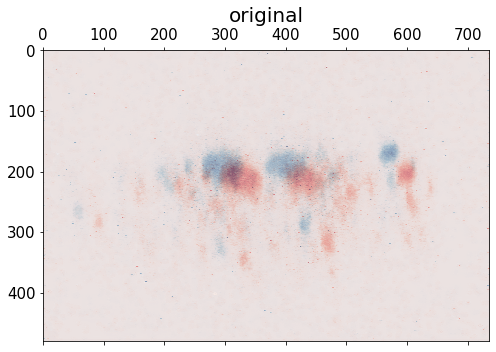

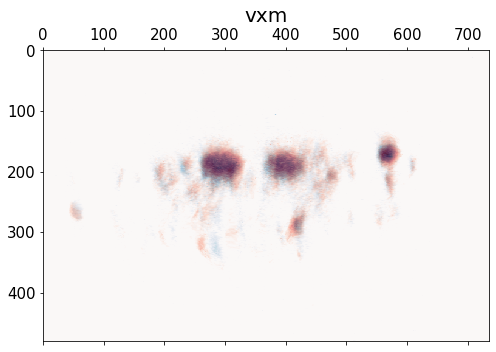

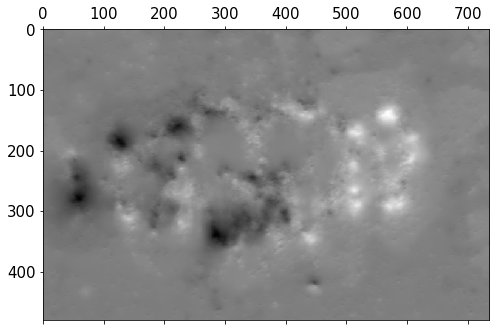

(480, 736, 1)


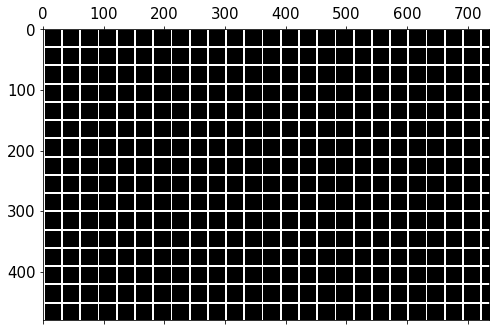

grid.shape=(1, 480, 736, 1)
in_shape=(480, 736)
warp.shape=(1, 480, 736, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deform_field.shape=(1, 480, 736, 1)


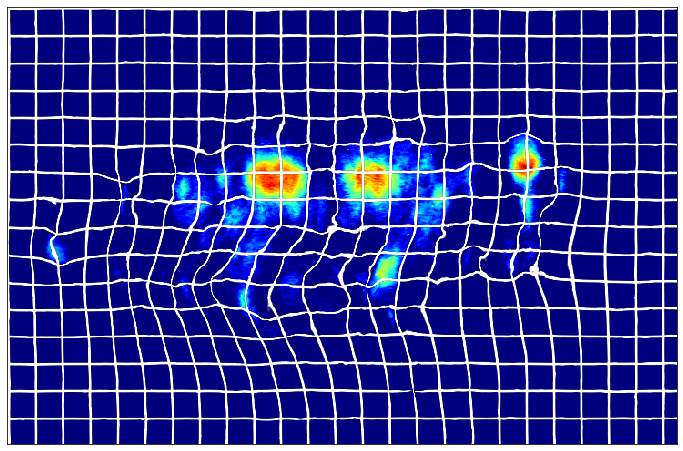

In [64]:
image = tiff.imread(orig_examples[0], key=[1, 1438])

_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(image[0], cmap='Blues')
ax.matshow(image[1], cmap='Reds', alpha=0.5)
ax.set_title('original')
plt.show()

_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(val_pred[0][0, ..., 0], cmap='Blues')
ax.matshow(val_pred[0][1, ..., 0], cmap='Reds', alpha=0.5)
ax.set_title('vxm')
plt.show()

_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(val_pred[1][1, ..., 0], cmap='gray')
plt.show()

sh = val_pred[0].shape[1:]
print(sh)
grid = np.zeros(sh)
ds = 30
grid[::ds, :] = 1.0
grid[1::ds, :] = 1.0
grid[2::ds, :] = 1.0
grid[:, ::ds] = 1.0
grid[:, 1::ds] = 1.0
grid[:, 2::ds] = 1.0
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.matshow(grid, cmap='gray')
plt.show()

grid = grid[np.newaxis, ...]
print(f'{grid.shape=}')
print(f'{in_shape=}')
warp = val_pred[1][1][np.newaxis, ...]
print(f'{warp.shape=}')

deform_field = vxm.networks.Transform(in_shape, nb_feats=1)\
        .predict([grid, warp])
print(f'{deform_field.shape=}')

deform_field = np.tile(deform_field[0], (1, 1, 4))
# deform_field[..., 3] = deform_field[..., 

_, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.matshow(val_pred[0][1], cmap='jet')
ax.matshow(deform_field, cmap='gray')
ax.tick_params(left=False,
                bottom=False,
                top=False,
                labeltop=False,
                labelleft=False,
                labelbottom=False)
plt.savefig('report/title/title.svg')
plt.show()

# Dataset overview

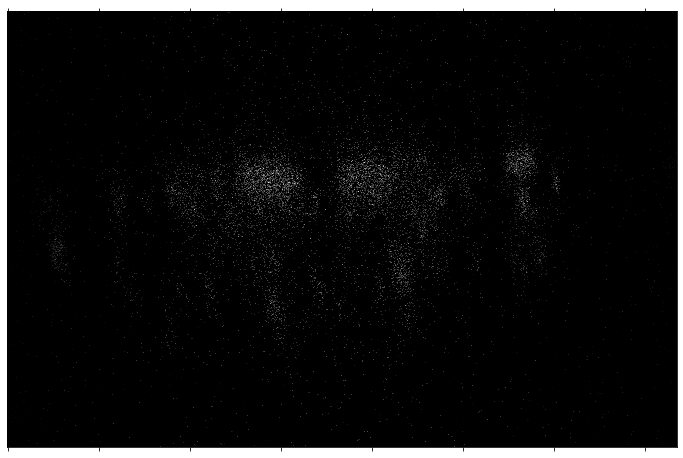

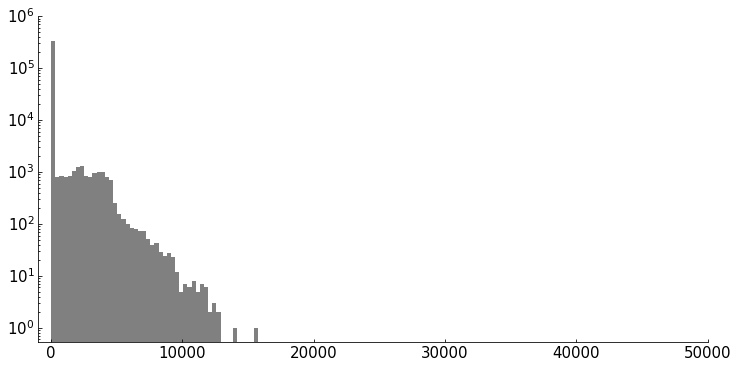

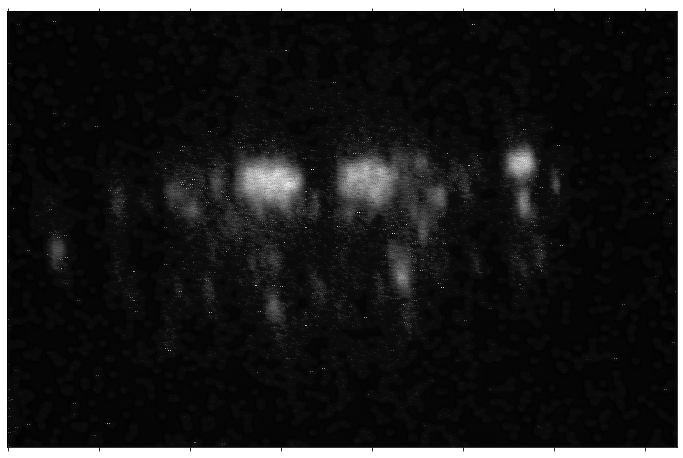

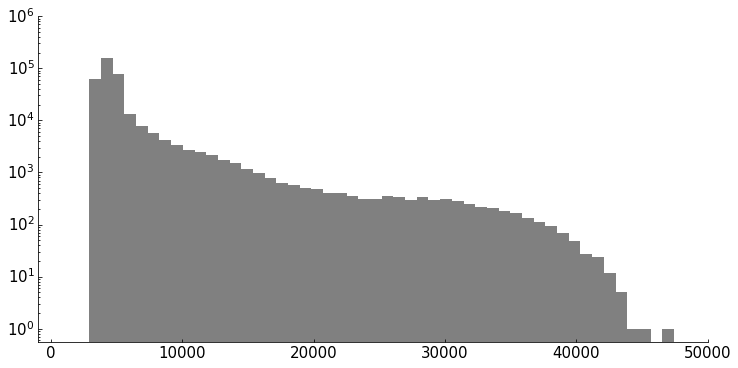

In [37]:
os.makedirs('report/dataset-overview', exist_ok=True)

def plot(path, name):
    img = tiff.imread(path, key=0)
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(1,1,1)
    ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    ax.matshow(img, cmap='gray')

    plt.savefig(f'report/dataset-overview/{name}.svg')
    plt.show()

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1, axes_class=AA.Axes)
    for direction in ["right", "top"]:
        # hides borders
        ax.axis[direction].set_visible(False)
    ax.set_yscale('log')
    ax.hist(img.ravel(), bins=50, color='gray')
    ax.set_ylim(None, 1e6)
    ax.set_xlim(-1000, 50_000)

    plt.savefig(f'report/dataset-overview/{name}-hist.svg')
    plt.show()
    

path = '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/red.tif'
plot(path, 'raw')



path = '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif'
plot(path, 'denoised')

# Metrics

In [2]:
from stabilize2p.utils import plot_centers

os.makedirs('report/metrics', exist_ok=True)

In [4]:
from stabilize2p.utils import get_centers

cs = []
for path in orig_examples:
    print(f'reading {path} ..')
    image = tiff.imread(path)
    cs.append(get_centers(image))
cs = np.array(cs)
np.save('report/metrics/centers', cs)
print(f'{cs.shape=}')

reading ../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif ..
reading ../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif ..
cs.shape=(9, 4100, 2)


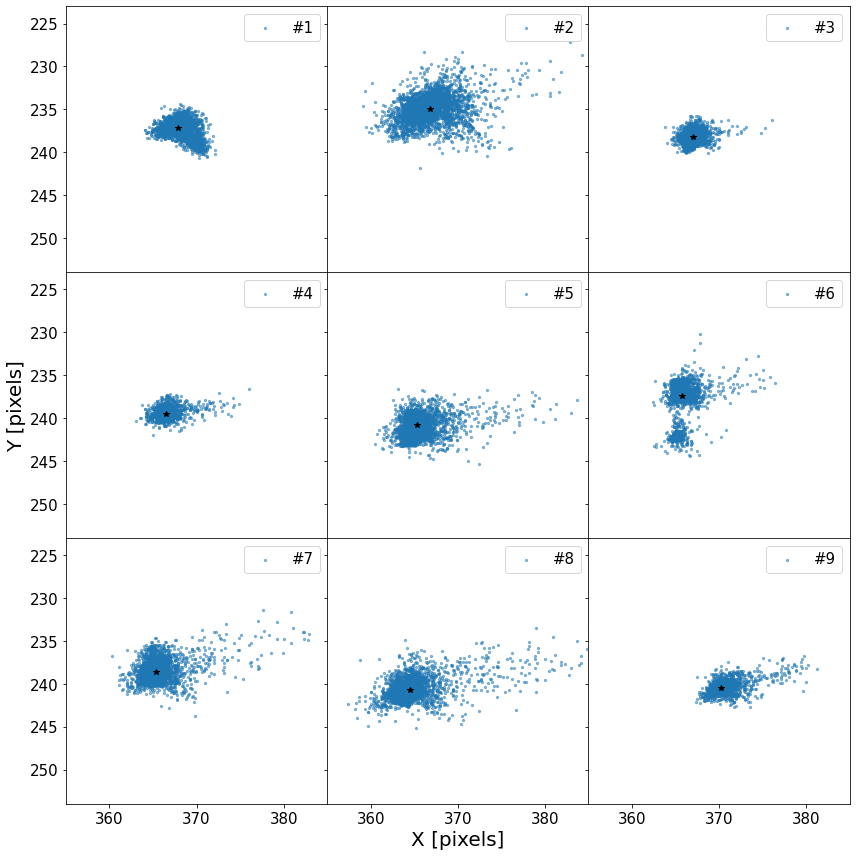

In [11]:
def plot_centers(centers, ax, label):
    size = 5
    target = centers.mean(axis=0)

    ax.scatter(centers[:, 0], centers[:, 1], color='tab:blue', s=size, alpha=0.5, label=label)
    ax.plot(target[0], target[1], 'k*')

    
cs = np.load('report/metrics/centers.npy')
_, axes = plt.subplots(3, 3, figsize=(4*3, 4*3),
                       sharex='all', sharey='all',
                       gridspec_kw=dict(wspace=0, hspace=0))

for i, ax in enumerate(axes.ravel()):
    plot_centers(cs[i], ax=ax, label=f'#{i+1}')
    ax.set_xlim(355, 385)
    ax.set_ylim(254, 223)
    ax.legend()

axes[1, 0].set_ylabel(r'Y [pixels]')
axes[2, 1].set_xlabel(r'X [pixels]')

plt.tight_layout()
plt.savefig('report/metrics/com-example.png')

# Thresholding

In [88]:
from stabilize2p import threshold

os.makedirs('report/thresholding', exist_ok=True)

methods = [
    threshold.otsu,
    threshold.triangle,
    threshold.watershed,
    threshold.second_deriv
]

path='../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_green.tif'
otsu: $T=385$
triangle: $T=267$
watershed: $T=186$
second_deriv: $T=202$


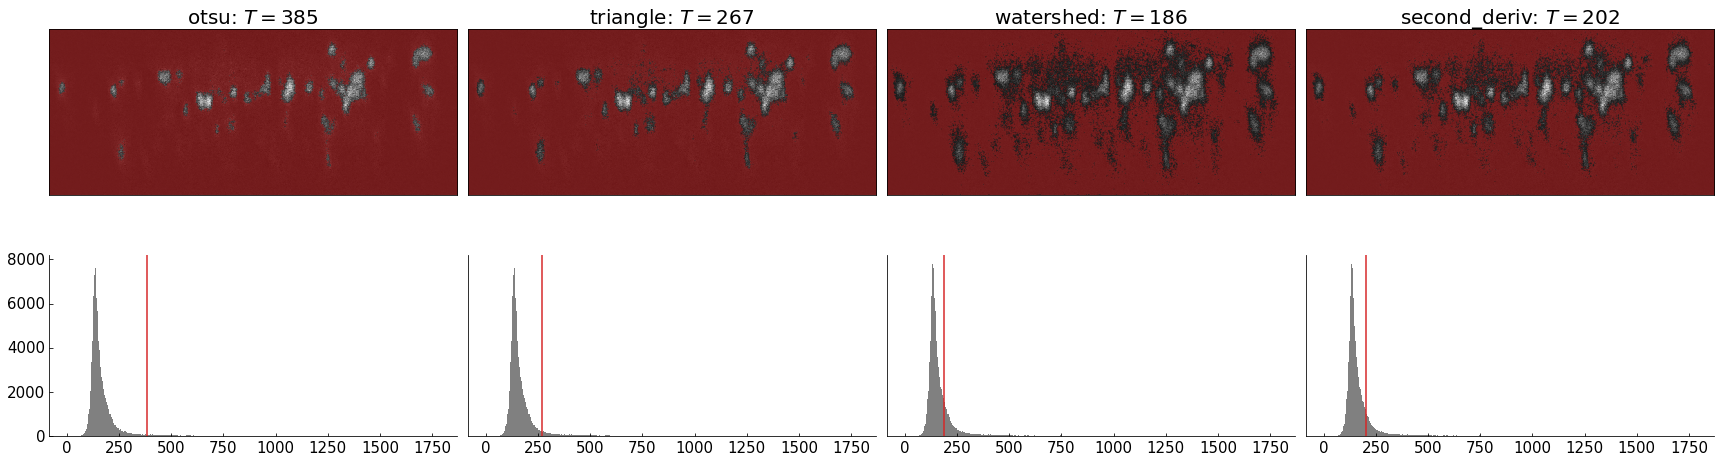

In [194]:

green = True

if green:
    path = orig_examples[0].replace('red', 'green')
else:
    path = orig_examples[0]
print(f'{path=}')
image = tiff.imread(path, key=0)
mask_color = mcolors.to_rgb(mcolors.TABLEAU_COLORS['tab:red'])

fig, axes = plt.subplots(2, len(methods),
                         figsize=(6*len(methods), 4*2),
                         subplot_kw=dict(axes_class=AA.Axes),
                         gridspec_kw=dict(height_ratios=[0.7, 0.3]),
                         sharey='row', sharex='row')

# apply thresholds
for i, meth, ax in zip(range(len(methods)), methods, axes.T):
    th = meth(image)
    title = f'{meth.__name__}: $T='f'{th:,.0f}$'.replace(',', '\'')
    print(title)
    
    ax[0].matshow(image, cmap='gray')

    alpha = 0.5
    mask = (image < th).astype(float) * alpha
    mask = np.tile(mask[..., np.newaxis], (1, 1, 4))
    mask[..., [0, 1, 2]] = mask_color
    ax[0].imshow(mask)

    for direction in ["right", "top", "bottom", "left"]:
        ax[0].axis[direction].major_ticks.set_visible(False)
        ax[0].axis[direction].major_ticklabels.set_visible(False)
    ax[0].set_title(title)

    # histogram
    for direction in ["right", "top"]:
        # hides borders
        ax[1].axis[direction].set_visible(False)
    if i > 0:
        ax[1].axis['left'].major_ticks.set_visible(False)
        ax[1].axis['left'].major_ticklabels.set_visible(False)
    # ax[1].set_yscale('log')
    ax[1].hist(image.ravel(), bins=600, color='gray')
    ax[1].axvline(th, c='tab:red')
    # ax.set_ylim(None, 1e6)
    if green:
        pass
    else:
        ax[1].set_xlim(None, 30_000)

plt.tight_layout()
if green:
    plt.savefig('report/thresholding/thresholds-green.svg')
else:
    plt.savefig('report/thresholding/thresholds.svg')
plt.show();

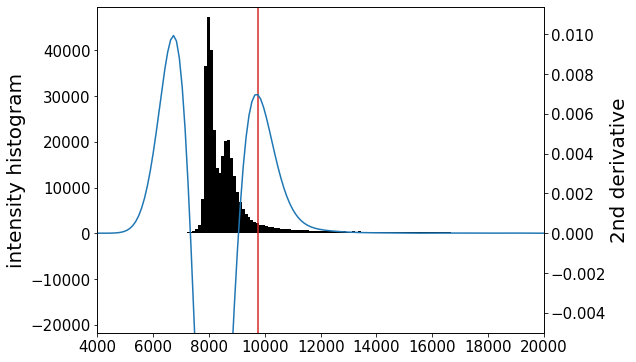

In [153]:
import cv2
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

hist, bns = np.histogram(image, bins=400)
dx = bns[1] - bns[0]
grad = (hist[1:] - hist[:-1]) / dx
grad = cv2.GaussianBlur(grad, (1, 31), 0)
grad2 = (grad[1:] - grad[:-1]) / dx
grad2 = cv2.GaussianBlur(grad2, (1, 31), 0)
coords = peak_local_max(grad2.ravel(), num_peaks=2)

i = coords.max()
T = bns[i:(i+1)].mean()

xaxis = bns.ravel()[:-1]

_, ax = plt.subplots(1,1,figsize=(8, 6))
ax.bar(xaxis, hist.ravel(), width=dx, color='black')
ax.set_ylabel('intensity histogram')
twinax = ax.twinx()
twinax.plot(xaxis[:-2], grad2.ravel(), color='tab:blue')
twinax.set_ylim(-0.005, None)
twinax.set_ylabel('2nd derivative')
ax.axvline(T, c='tab:red')
ax.set_xlim(4000, 20_000)

l1, h1 = ax.get_ylim()
l2, h2 = twinax.get_ylim()
ax.set_ylim(h1/h2 * l2, h1)

plt.savefig('report/thresholding/second-deriv.svg')
plt.show()

# Normalization

image.min()=-0.6705882352944172
gs=GridSpec(1, 2)


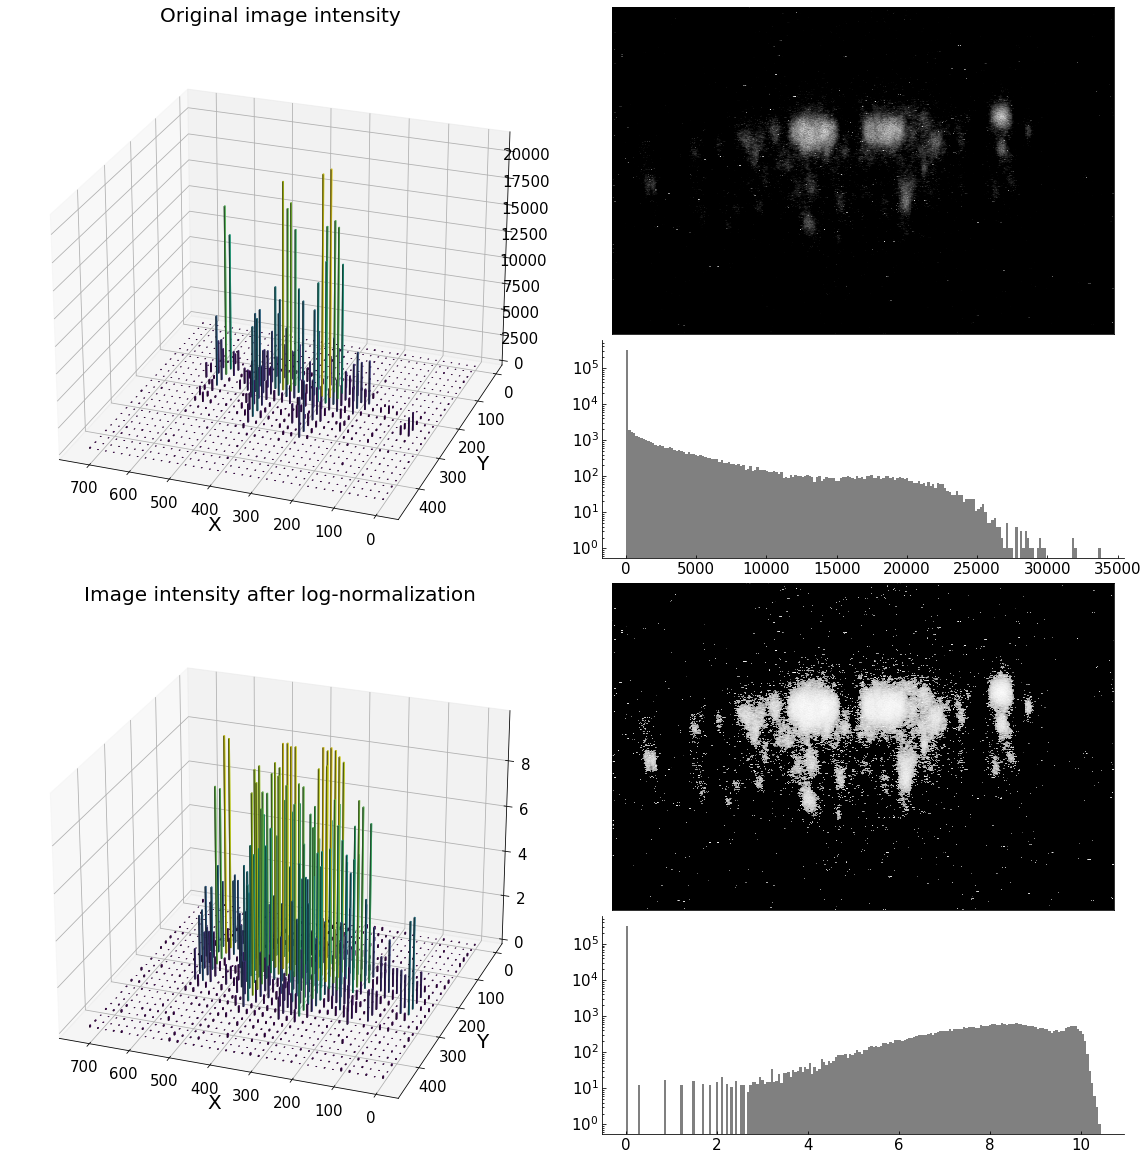

In [186]:
from stabilize2p import threshold
from stabilize2p.utils import plot_frame_values_3d
import matplotlib.gridspec as gridspec
image = tiff.imread(orig_examples[0], key=0)

os.makedirs('report/normalization', exist_ok=True)

th = threshold.triangle(image)
np.clip(image, th, None, out=image)
image = image - th
print(f'{image.min()=}')

## PLOT
fig = plt.figure(figsize=(16, 16), constrained_layout=True)

gs = gridspec.GridSpec(1, 2, figure=fig)
print(f'{gs=}')

def plot_img(fig, sub_gs):
    ax = fig.add_subplot(sub_gs[0], axes_class=AA.Axes)
    ax.matshow(image, cmap='gray')
    for direction in ["right", "top", "bottom", "left"]:
        ax.axis[direction].major_ticks.set_visible(False)
        ax.axis[direction].major_ticklabels.set_visible(False)
    ax = fig.add_subplot(sub_gs[1], axes_class=AA.Axes)
    ax.hist(image.ravel(), bins=200, color='gray')
    ax.set_yscale('log')
    for direction in ["right", "top"]:
        # hides borders
        ax.axis[direction].set_visible(False)


gs_3d = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0])
sub_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[1],
                                          height_ratios=[0.3, 0.2, 0.3, 0.2])

ax = fig.add_subplot(gs_3d[0], projection='3d')
plot_frame_values_3d(image, ax=ax, pool=20, cmap='viridis')
ax.set_title(r'Original image intensity')

plot_img(fig, sub_gs)

I = image
# l, h = I.min(), I.max()
# I = (I - l) / (h - l)
image = np.clip(np.log(1 + I), 0, None)

ax = fig.add_subplot(gs_3d[1], projection='3d')
plot_frame_values_3d(image, ax=ax, pool=20, cmap='viridis')
ax.set_title(r'Image intensity after log-normalization')

plot_img(fig, [sub_gs[2], sub_gs[3]])

plt.savefig('report/normalization/log-norm.svg')
plt.show()

# PyStackReg

path='../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif'
radius=48.0
x: 361.84 + 3.38
y: 220.37 + 1.32


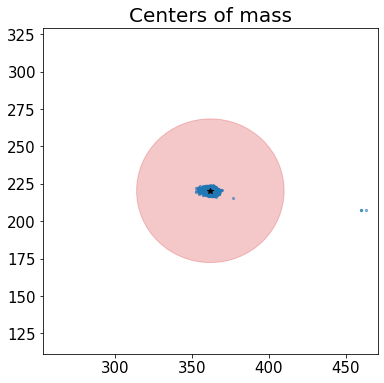

COM: 0.0732%


In [17]:
from stabilize2p.metrics import COM
from stabilize2p.utils import plot_centers, vxm_preprocessing

os.makedirs('report/pystackreg', exist_ok=True)

path = pystackreg_examples[1]
print(f'{path=}')
image = tiff.imread(path)

t1 = time.perf_counter()
image, params = vxm_preprocessing(image, affine_transform=False)
gc.collect()
t2 = time.perf_counter()
print(f'pre-processed image in {t2-t1}s')

plt.figure(figsize=(6, 6))
plot_centers(image)
plt.savefig('report/pystackreg/pysreg-com-exapmle.svg')
plt.show()

com = COM(image)
print(f'COM: {com*100:.4f}%')

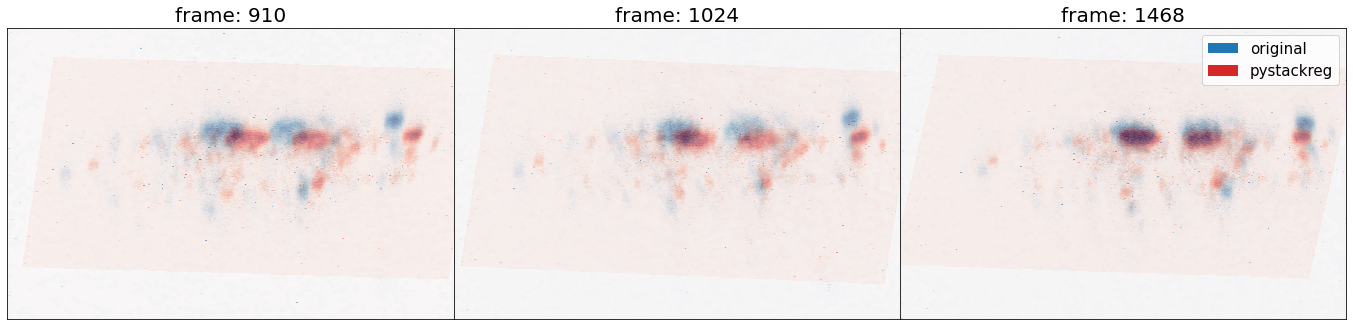

In [22]:
from matplotlib.patches import Patch


# fails = COM(image, return_all=True)
fails_idx = np.where(fails)[0]


_, axes = plt.subplots(1, len(fails_idx),
                       figsize=(8*len(fails_idx), 6),
                       gridspec_kw=dict(wspace=0),
                       subplot_kw=dict(axes_class=AA.Axes))
for i, ax in zip(fails_idx, axes):
    orig_img = tiff.imread(orig_examples[1], key=i)
    img = tiff.imread(path, key=i)
    # undo pre-processing
    # h, l = params['hig'], params['low']
    # img = img * (h - l) + l
    # img = np.exp(img) - 1
    # img = img + params['bg_thresh']

    ax.matshow(orig_img, cmap='Blues')
    ax.matshow(img, cmap='Reds', alpha=0.5)
    for direction in ["right", "top", "bottom", "left"]:
        ax.axis[direction].major_ticks.set_visible(False)
        ax.axis[direction].major_ticklabels.set_visible(False)
    ax.set_title(f'frame: {i}')

    del orig_img, img
    gc.collect()

ax.legend(handles=[
            Patch(facecolor='tab:blue', label=r'original'),
            Patch(facecolor='tab:red', label=r'pystackreg'),
          ],
          loc='upper right')
plt.savefig('report/pystackreg/pysreg-fail-examples.svg')
plt.show()

# Voxelmorph

## architecture input-output frames

In [82]:
import os
from stabilize2p.utils import vxm_preprocessing
os.makedirs('report/voxelmorph', exist_ok=True)

key = range(2000, 2008)
image = tiff.imread(orig_examples[4], key=key)
processed, params = vxm_preprocessing(image)
del image
print(f'{processed.shape=}')

def transform(I, to_uint=True):
    if to_uint:
        l, h = I.min(), I.max()
        I = (I-l)/(h-l) * 255
        I = I.astype('uint8')
        I = cv2.applyColorMap(I, cv2.COLORMAP_VIRIDIS)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    _, W, C = I.shape
    I = np.concatenate([I, 255*np.ones((I.shape[0], W, 1), dtype='uint8')], axis=2)
    margins_up = np.zeros((I.shape[0]//3, W, C+1), dtype='uint8')
    margins_down = np.zeros((I.shape[0]//2, W, C+1), dtype='uint8')
    I = np.concatenate([margins_up, I, margins_down], axis=0)
    H = I.shape[0]
    M2 = np.float32([[1, 0, 0], [-0.5, 1, 0]])
    M2[0,2] = -M2[0,1] * W/2
    M2[1,2] = -M2[1,0] * H/2
    I = cv2.warpAffine(I, M2, (W, H))
    I = cv2.resize(I, (W//2, H))
    return I

for i, I in enumerate(processed):
    I = transform(I)

    _, ax = plt.subplots(1, 1,
                         subplot_kw=dict(axes_class=AA.Axes))
    for direction in ["right", "top", "bottom", "left"]:
        ax.axis[direction].set_visible(False)
    ax.imshow(I)
    plt.savefig(f'report/voxelmorph/in_{i}.svg', transparent=True)
    plt.close()

# load vxm model and predict
vxm_model = vxm.networks.VxmDense.load('../models/vxm_drosophila_2d_1900.h5')
fixed = np.concatenate([processed[:1], processed[:-1]], axis=0)
print(f'{fixed.shape=}')
moved, flow = vxm_model.predict([processed[..., np.newaxis], fixed[..., np.newaxis]])
moved, flow = moved.squeeze(), flow.squeeze()
del fixed
print(f'{moved.shape=}')

for i, I in enumerate(moved):
    I = transform(I)

    _, ax = plt.subplots(1, 1,
                         subplot_kw=dict(axes_class=AA.Axes))
    for direction in ["right", "top", "bottom", "left"]:
        ax.axis[direction].set_visible(False)
    ax.imshow(I)
    plt.savefig(f'report/voxelmorph/out_{i}.svg', transparent=True)
    plt.close()

for i, f in enumerate(flow):
    ne.plot.flow([f[::10, ::10]], show=False)
    plt.savefig(f'report/voxelmorph/flow_out_{i}.png')
    plt.close()
    
    I = cv2.imread(f'report/voxelmorph/flow_out_{i}.png')
    I = transform(I, to_uint=False)

    _, ax = plt.subplots(1, 1,
                         subplot_kw=dict(axes_class=AA.Axes))
    for direction in ["right", "top", "bottom", "left"]:
        ax.axis[direction].set_visible(False)
    ax.imshow(I)
    plt.savefig(f'report/voxelmorph/flow_out_{i}.svg', transparent=True)
    plt.close()
print('Done')

[2022-01-11 00:56:38,590] D T140509901460288 utils.py:383: Applied affine transform to 8 frames at a rate of 40 frames/s


processed.shape=(8, 480, 736)
fixed.shape=(8, 480, 736)
moved.shape=(8, 480, 736)
Done


In [83]:
!rm report/voxelmorph/*.png

/bin/bash: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Results

## COM threshold sensitivity analysis

In [7]:
import gc
from stabilize2p.utils import vxm_preprocessing, get_centers

def COM(centers, threshold):
    # consider a frame wrong if the axis is > 10% off the mean
    m_center = centers.mean(axis=0)
    failures = np.sum((centers - m_center)**2, axis=1) > threshold**2
    return np.sum(failures) / centers.shape[0]

In [20]:
orig_centers = []
for fp in orig_examples:
    print(f'reading {fp} ..')
    x = tiff.imread(fp)
    image, _ = vxm_preprocessing(x, affine_transform=False)
    print('finished preproc')

    orig_centers.append(get_centers(image))
    del image
    gc.collect()
orig_centers = np.array(orig_centers)
np.save('report/pystackreg/orig_centers', orig_centers)

pysreg_centers = []
for fp in pystackreg_examples:
    print(f'reading {fp} ..')
    x = tiff.imread(fp)
    image, _ = vxm_preprocessing(x, affine_transform=False)
    print('finished preproc')

    pysreg_centers.append(get_centers(image))
    del image
    gc.collect()
pysreg_centers = np.array(pysreg_centers)
np.save('report/pystackreg/pysreg_centers', pysreg_centers)


ofco_centers = []
for fp in ofco_examples[5:]:
    print(f'reading {fp} ..')
    x = tiff.imread(fp)
    image, _ = vxm_preprocessing(x, affine_transform=False)
    print('finished preproc')

    ofco_centers.append(get_centers(image))
    del image
    gc.collect()
ofco_centers = np.array(ofco_centers)
np.save('report/pystackreg/ofco_centers', ofco_centers)

reading ../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif ..
finished preproc
reading ../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif ..
finished preproc


In [24]:
# scores
MAX_TH = 100
thresholds = np.linspace(0, MAX_TH, 100)
orig_scores = []
pysreg_scores = []
ofco_scores = []
for th in thresholds:
    orig_scores.append([
        COM(cs, th) * 100.0
        for cs in orig_centers
    ])
    pysreg_scores.append([
        COM(cs, th) * 100.0
        for cs in pysreg_centers
    ])
    ofco_scores.append([
        COM(cs, th) * 100.0
        for cs in ofco_centers
    ])
orig_scores = np.array(orig_scores).T
pysreg_scores = np.array(pysreg_scores).T
ofco_scores = np.array(ofco_scores).T
print(f'{orig_scores.shape=} | {pysreg_scores.shape=} | {ofco_scores.shape=}')

orig_scores.shape=(9, 100) | pysreg_scores.shape=(9, 100) | ofco_scores.shape=(9, 100)


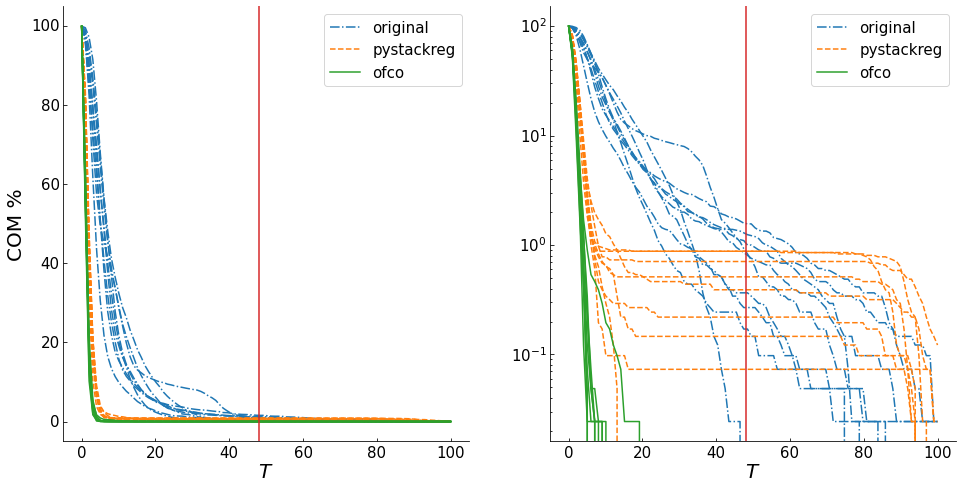

In [64]:
xaxis = thresholds
T = 48

fig, axes = plt.subplots(1, 2, figsize=(8*2, 8), subplot_kw=dict(axes_class=AA.Axes))

cmap = plt.get_cmap('tab10')
line_styles = ['-.', '--', '-']

# AX 0
ax = axes[0]
i = 0
for scores, label in [(orig_scores, 'original'), (pysreg_scores, 'pystackreg'), (ofco_scores, 'ofco')]:
    for si, com_vals in enumerate(scores):
        ax.plot(xaxis, com_vals, c=cmap(i), ls=line_styles[i], label=(label if si == 0 else None))
    i += 1

ax.axvline(T, c='tab:red')

for direction in ["right", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'COM %')
ax.legend()

# AX 1
ax = axes[1]
ax.set_yscale('log')
i = 0
for scores, label in [(orig_scores, 'original'), (pysreg_scores, 'pystackreg'), (ofco_scores, 'ofco')]:
    for si, com_vals in enumerate(scores):
        ax.plot(xaxis, com_vals, c=cmap(i), ls=line_styles[i], label=(label if si == 0 else None))
    i += 1

ax.axvline(T, c='tab:red')

for direction in ["right", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)
ax.set_xlabel(r'$T$')
ax.legend()

plt.savefig('report/pystackreg/com-thresh-analysis.svg')
plt.show();

### All COM, MSE results PyStackReg

In [2]:
import gc
from stabilize2p.metrics import COM, MSE
from stabilize2p.utils import plot_centers, vxm_preprocessing

for path in pystackreg_examples:
    print(f'{path=}')
    image = tiff.imread(path)
    print('loaded image')

    t1 = time.perf_counter()
    image, params = vxm_preprocessing(image, affine_transform=False)
    t2 = time.perf_counter()
    print(f'pre-processed image in {t2-t1}s')

    com = COM(image)
    mse = MSE(image, ref='previous')
    print(f'COM: {com*100:.4f}% | MSE: {mse}')
    
    del image
    gc.collect()

path='../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif'
loaded image
pre-processed image in 39.50352100099553s
COM: 0.0000% | MSE: 0.022736924949652633
path='../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif'
loaded image
pre-processed image in 39.45256643000175s
COM: 0.0732% | MSE: 0.026599499479064856
path='../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif'
loaded image
pre-processed image in 43.464456288988s
COM: 0.2195% | MSE: 0.03017135715961857
path='../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif'
loaded image
pre-processed image in 41.46008265198907s
COM: 0.1463% | MSE: 0.0225573349740112
path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
loaded image
pre-processed image in 41.32735349799623s
COM: 0.8780% | MSE: 0.025325377195480562
path='../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.pystackreg-aff

In [2]:
coms = np.array([
    0.0000,0.0732,0.2195,0.1463,0.8780,0.3902,0.7073,0.5122,0.8780
])
print(f'com: {coms.mean()} +- {coms.std()}')
mses = np.array([
    0.0227, 0.0266, 0.0302, 0.0226, 0.0253, 0.0237, 0.0222, 0.0242, 0.0261
])
print(f'mse: {mses.mean()} +- {mses.std()}')

com: 0.4227444444444445 +- 0.32027289791020797
mse: 0.024844444444444447 +- 0.002401439897279737


### COM+ECC COM results

In [3]:
import gc
import logging
from stabilize2p.metrics import COM, MSE
from stabilize2p.utils import plot_centers, vxm_preprocessing

os.makedirs('report/com_ecc', exist_ok=True)

logging.getLogger('stabilize2p').setLevel(logging.DEBUG)


for path in orig_examples:
    print(f'{path=}')
    image = tiff.imread(path)
    print('loaded image')

    t1 = time.perf_counter()
    image, params = vxm_preprocessing(image, affine_transform=True)
    t2 = time.perf_counter()
    print(f'pre-processed image in {t2-t1}s')

    com = COM(image)
    mse = MSE(image, ref='previous')
    print(f'COM: {com*100:.4f}% | MSE: {mse}')
    
    del image
    gc.collect()

path='../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif'
loaded image


[2022-01-09 23:40:43,140] D T140635422352192 utils.py:375: Applied affine transform to 4100 frames at a rate of 57 frames/s


pre-processed image in 89.04676363401813s
COM: 0.0000% | MSE: 0.013462658040225506
path='../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif'
loaded image


[2022-01-09 23:42:17,441] D T140635422352192 utils.py:375: Applied affine transform to 4100 frames at a rate of 57 frames/s


pre-processed image in 89.24329409300117s
COM: 0.0000% | MSE: 0.014785115607082844
path='../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif'
loaded image


[2022-01-09 23:43:51,823] D T140635422352192 utils.py:375: Applied affine transform to 4100 frames at a rate of 57 frames/s


pre-processed image in 89.27753110602498s
COM: 0.0000% | MSE: 0.014487281441688538
path='../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif'
loaded image


[2022-01-09 23:45:26,318] D T140635422352192 utils.py:375: Applied affine transform to 4100 frames at a rate of 56 frames/s


pre-processed image in 89.48183624801459s
COM: 0.0000% | MSE: 0.011694387532770634
path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
loaded image


[2022-01-09 23:47:00,996] D T140635422352192 utils.py:375: Applied affine transform to 4100 frames at a rate of 57 frames/s


pre-processed image in 89.34877056599362s
COM: 0.0000% | MSE: 0.013349038548767567
path='../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif'
loaded image


[2022-01-09 23:48:35,590] D T140635422352192 utils.py:375: Applied affine transform to 4100 frames at a rate of 57 frames/s


pre-processed image in 89.3156772889779s
COM: 0.0000% | MSE: 0.011486541479825974
path='../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif'
loaded image


[2022-01-09 23:50:10,274] D T140635422352192 utils.py:375: Applied affine transform to 4100 frames at a rate of 57 frames/s


pre-processed image in 89.46423362600035s
COM: 0.0000% | MSE: 0.011646593920886517
path='../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif'
loaded image


[2022-01-09 23:51:44,853] D T140635422352192 utils.py:375: Applied affine transform to 4100 frames at a rate of 57 frames/s


pre-processed image in 89.14720817000489s
COM: 0.0000% | MSE: 0.014125972054898739
path='../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif'
loaded image


[2022-01-09 23:53:19,192] D T140635422352192 utils.py:375: Applied affine transform to 4100 frames at a rate of 57 frames/s


pre-processed image in 89.32816708800965s
COM: 0.0000% | MSE: 0.014574266970157623


In [5]:
mses = np.array([
    0.0135, 0.0148, 0.0145, 0.0117, 0.0133, 0.0115, 0.0116, 0.0141, 0.0146
])
print(f'mse: {mses.mean()} +- {mses.std()}')

mse: 0.01328888888888889 +- 0.001280142738954827


## Method scores

In [3]:
import gc
import logging
from tqdm import tqdm
from stabilize2p.metrics import COM, MSE, NCC, EMD
from stabilize2p.utils import plot_centers, vxm_preprocessing, get_strategy

os.makedirs('report/results', exist_ok=True)

logging.getLogger('stabilize2p').setLevel(logging.DEBUG)

strategy = get_strategy('default')

[2022-01-10 19:09:43,682] I T140509901460288 utils.py:1243: Num Physical GPUs Available: 0
[2022-01-10 19:09:43,689] I T140509901460288 utils.py:1244: Num Logical  GPUs Available: 0
[2022-01-10 19:09:43,712] I T140509901460288 utils.py:1245: Num TPUs Available: 0
[2022-01-10 19:09:43,713] I T140509901460288 utils.py:1275: using default strategy.


In [8]:
# PYSREG
path = pystackreg_examples[4]

print(f'{path=}')
image = tiff.imread(path)
print('loaded image')

t1 = time.perf_counter()
image, params = vxm_preprocessing(image, affine_transform=False)
t2 = time.perf_counter()
print(f'pre-processed image in {t2-t1}s')

com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

del image
gc.collect()

path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
loaded image
pre-processed image in 33.88856728000064s
COM: 0.8780%
MSE: 0.025325377195480562
NCC: -0.578834593296051


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [23:14<00:00, 139.44s/it]

EMD: 17.206642734311536 +- 0.029764773648707468 | emd_scores=[17.187346225462957, 17.240802744235634, 17.191420606315983, 17.205780755839914, 17.24518667674609, 17.19060855185228, 17.183422440172286, 17.263753360651364, 17.17575331692255, 17.182352664916312]


26

In [7]:
# COM-T+ECC
path = orig_examples[4]

print(f'{path=}')
image = tiff.imread(path)
print('loaded image')

t1 = time.perf_counter()
image, params = vxm_preprocessing(image, affine_transform=True)
t2 = time.perf_counter()
print(f'pre-processed image in {t2-t1}s | {image.shape[0]/(t2-t1)} frames/s')

com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

del image
gc.collect()

path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
loaded image


[2022-01-10 20:24:06,721] D T140509901460288 utils.py:383: Applied affine transform to 4100 frames at a rate of 31 frames/s


pre-processed image in 165.84162784100045s | 24.72238154783941 frames/s
COM: 0.0000%
MSE: 0.013349038548767567
NCC: -0.4587291181087494


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [20:00<00:00, 120.07s/it]

EMD: 30.528223600322754 +- 0.04560486000452212 | emd_scores=[30.511363660729874, 30.58840883082746, 30.553402003753682, 30.602474990147805, 30.554830182623704, 30.45381669712575, 30.51606152872361, 30.532819696404438, 30.500537867751227, 30.468520545139995]


26

In [4]:
# OFCO
path = ofco_examples[4]

print(f'{path=}')
image = tiff.imread(path)
print('loaded image')

t1 = time.perf_counter()
image, params = vxm_preprocessing(image, affine_transform=False)
t2 = time.perf_counter()
print(f'pre-processed image in {t2-t1}s')

com = COM(image)
print(f'COM: {com*100:.4f}%')
mse = MSE(image, ref='previous')
print(f'MSE: {mse}')
ncc = NCC(image, ref='previous')
print(f'NCC: {ncc}')
emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]
print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)} | {emd_scores=}')

del image
gc.collect()

path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
loaded image
pre-processed image in 30.87372674300059s
COM: 0.0000%
MSE: 0.01872944843566874
NCC: -0.6368662118911743
EMD: 15.582152576301468


0

In [6]:
from tqdm import tqdm
# # OFCO
# path = ofco_examples[4]

# print(f'{path=}')
# image = tiff.imread(path)
# print('loaded image')

# t1 = time.perf_counter()
# image, params = vxm_preprocessing(image, affine_transform=False)
# t2 = time.perf_counter()
# print(f'pre-processed image in {t2-t1}s')

emd_scores = []
for _ in tqdm(range(10)):
    emd_scores += [EMD(image, ref='previous')]

print(f'EMD: {np.mean(emd_scores)} +- {np.std(emd_scores)}')

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [24:54<00:00, 149.49s/it]

EMD: 15.650980508476371 +- 0.04056713343819057
